# 1) Image Retrieval
Assuming the presence of thousands of images within the map database, the task of determining the pose of a query image necessitates the **initial identification of similar images fastly**. This critical step is known as **image retrieval**. Let's load few thousands of images, describe them by multiple methods and find the most similar images.

In [15]:
%load_ext autoreload
%autoreload 2
import random, time
from pathlib import Path
from pprint import pformat
from hloc import (
    extract_features,
    match_features,
    pairs_from_covisibility,
    pairs_from_retrieval,
)
from hloc import colmap_from_nvm, triangulation, localize_sfm, visualization
from hloc.utils.downloader import *
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d
from hloc.extract_features import ImageDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
url = 'https://data.ciirc.cvut.cz/public/projects/2020VisualLocalization/Aachen-Day-Night/'
target_folder = '/data/aachen/'

if not (os.path.exists('/data/aachen/images_upright') and os.path.isdir('/data/aachen/images_upright')):
    download_files_from_directory(url, target_folder)
    unpack_zip('/data/aachen/images/database_and_query_images.zip', '/data/aachen')

# Visualise the database images 
We will use approx. 4.5k images in the database from Aachen-Day-Night dataset. 

[2024/02/07 23:07:42 hloc INFO] Found 4479 images in root /data/aachen/images_upright/db.


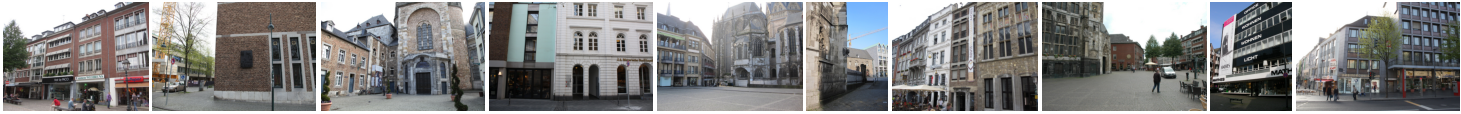

In [6]:
db_images_dir = Path("/data/aachen/images_upright/db")
db_images = ImageDataset(db_images_dir, {"resize_max": 1024}, None)
plot_images([read_image(db_images_dir / r) for r in random.sample(db_images.names, 10)], dpi=25)

# Visualise the query images 

[2024/02/07 23:08:05 hloc INFO] Found 947 images in root /data/aachen/images_upright/query.


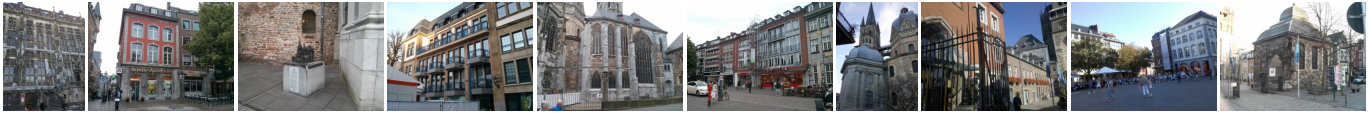

In [7]:
query_images_dir = Path("/data/aachen/images_upright/query")
query_images = ImageDataset(query_images_dir, {"resize_max": 1024}, None)
plot_images([read_image(query_images_dir / r) for r in random.sample(query_images.names, 10)], dpi=25)

# Create a subset of database and query iamges 

In [19]:
# TODO: this

# [OFFLINE] Describe database images
We first select the image descriptor and describe all the images in the database by feature vectors.

In [9]:
retrieval_conf = extract_features.confs['senet']       # dir, netvlad, openibl, eigenplaces, senet

In [11]:
outputs = Path("outputs/aachen")
global_descriptors = extract_features.main(retrieval_conf, db_images_dir, outputs)

[2024/02/07 23:10:12 hloc INFO] Extracting local features with configuration:
{'model': {'model_name': 'SENet_R50_con',
           'name': 'senet',
           'resnet_size': 50,
           'scale_list': [0.7071, 1.0, 1.4142]},
 'output': 'global-feats-senet',
 'preprocessing': {'resize_max': 1024}}
[2024/02/07 23:10:12 hloc INFO] Found 4479 images in root /data/aachen/images_upright/db.
[2024/02/07 23:10:13 hloc INFO] Skipping the extraction.


# [ONLINE] Describe query images

In [12]:
global_descriptors = extract_features.main(retrieval_conf, query_images_dir, outputs)

[2024/02/07 23:10:31 hloc INFO] Extracting local features with configuration:
{'model': {'model_name': 'SENet_R50_con',
           'name': 'senet',
           'resnet_size': 50,
           'scale_list': [0.7071, 1.0, 1.4142]},
 'output': 'global-feats-senet',
 'preprocessing': {'resize_max': 1024}}
[2024/02/07 23:10:31 hloc INFO] Found 947 images in root /data/aachen/images_upright/query.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 947/947 [00:48<00:00, 19.52it/s]
[2024/02/07 23:11:21 hloc INFO] Finished exporting features.


# [ONLINE] Find the pairs between the query and database images
Here we use the prefix in the directory paths "db" and "query" to distinguish between database and query images. This script finds **num_matched** most similar database images for a query image. 

In [18]:
start_time = time.time()
loc_pairs = outputs / "pairs-query-netvlad20.txt"  # top 20 retrieved by NetVLAD
pairs_from_retrieval.main(
    global_descriptors, loc_pairs, num_matched=20, db_list=db_images.names, query_list=query_images.names
)
print(f"Elapsed time: {(time.time() - start_time):.2f} seconds")

[2024/02/07 23:18:51 hloc INFO] Extracting image pairs from a retrieval database.
[2024/02/07 23:18:54 hloc INFO] Found 18940 pairs.


Elapsed time: 2.84 seconds
